In [1]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

In [6]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
csv_file_path = 'student_grades_updated.csv'

In [8]:
df = pd.read_csv(csv_file_path)
df.head()

,id,question,answer,nbestanswers,main_category,random_answer_list,similarities,Grades
0,2020338.0,Why did the U.S Invade Iraq ?,A small group of politicians believed strongly...,"[""A small group of politicians believed strong...",News & Events,['I think Yuval is pretty spot on. It\'s a pro...,[0.1988981679081917],F
1,2874684.0,How to get rid of a beehive?,Call an area apiarist. They should be able to...,['Call an area apiarist. They should be able ...,Education & Reference,['Call an area apiarist. They should be able ...,[0.9176195174455644],O
2,4193114.0,Why don't European restaurants serve water?,There's a general belief in Europe (and in fac...,"[""There's a general belief in Europe (and in f...",Society & Culture,['I\'d like to take a different approach in an...,[0.32846239209175115],F
3,3608897.0,Can someone explain the theory of e=mc2?,In general it means that in a very high speed ...,['In general it means that in a very high spee...,Science & Mathematics,['I think an expansion on the answer from the ...,[0.2550382271409035],F
4,2175566.0,"For colIege admission, is it better to take AP...",I used to work in a college admissions office ...,"[""I used to work in a college admissions offic...",Education & Reference,"[""I used to work in a college admissions offic...",[0.9337731510400772],O


In [9]:
sorted(df.Grades.unique())

['A', 'B', 'C', 'F', 'O']

In [10]:
def map_grade(grade_assigned):
    grade_assigned = str(grade_assigned)
    if grade_assigned == 'F':
        return 0
    elif grade_assigned == 'C':
        return 1
    elif grade_assigned == 'B':
        return 2
    elif grade_assigned == 'A':
        return 3
    elif grade_assigned == 'O':
        return 4
    
df['Grades'] = df.Grades.apply(map_grade)

In [11]:
df.head()

,id,question,answer,nbestanswers,main_category,random_answer_list,similarities,Grades
0,2020338.0,Why did the U.S Invade Iraq ?,A small group of politicians believed strongly...,"[""A small group of politicians believed strong...",News & Events,['I think Yuval is pretty spot on. It\'s a pro...,[0.1988981679081917],0
1,2874684.0,How to get rid of a beehive?,Call an area apiarist. They should be able to...,['Call an area apiarist. They should be able ...,Education & Reference,['Call an area apiarist. They should be able ...,[0.9176195174455644],4
2,4193114.0,Why don't European restaurants serve water?,There's a general belief in Europe (and in fac...,"[""There's a general belief in Europe (and in f...",Society & Culture,['I\'d like to take a different approach in an...,[0.32846239209175115],0
3,3608897.0,Can someone explain the theory of e=mc2?,In general it means that in a very high speed ...,['In general it means that in a very high spee...,Science & Mathematics,['I think an expansion on the answer from the ...,[0.2550382271409035],0
4,2175566.0,"For colIege admission, is it better to take AP...",I used to work in a college admissions office ...,"[""I used to work in a college admissions offic...",Education & Reference,"[""I used to work in a college admissions offic...",[0.9337731510400772],4


In [12]:
sorted(df.Grades.unique())

[0, 1, 2, 3, 4]

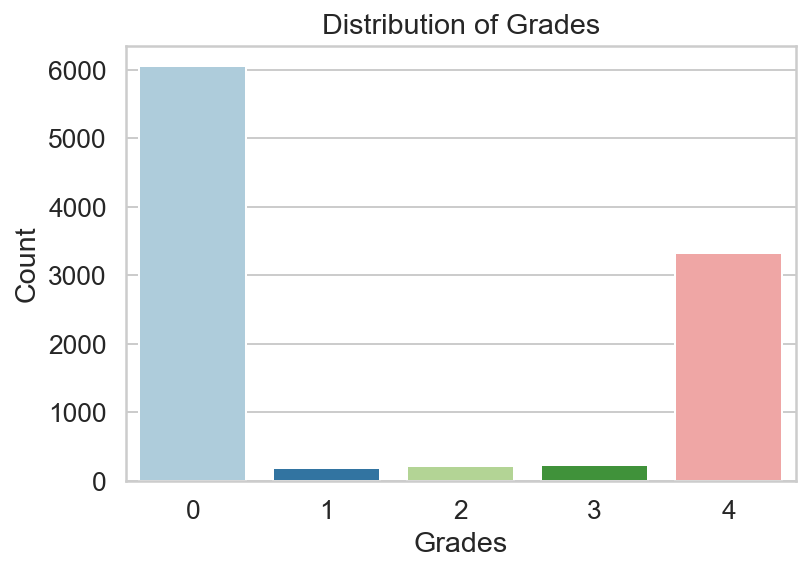

In [13]:
grade_counts = df['Grades'].value_counts()

sns.barplot(x=grade_counts.index, y=grade_counts.values)
plt.xlabel('Grades')
plt.ylabel('Count')
plt.title('Distribution of Grades')
plt.show()


In [14]:
answer = df.answer.to_list(),
random_answer_list = df.random_answer_list.to_list(),
target = df.Grades.to_list(),

In [16]:
pre_trained_model_ckpt = "bert-base-uncased"

In [17]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

C:\Users\omkar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

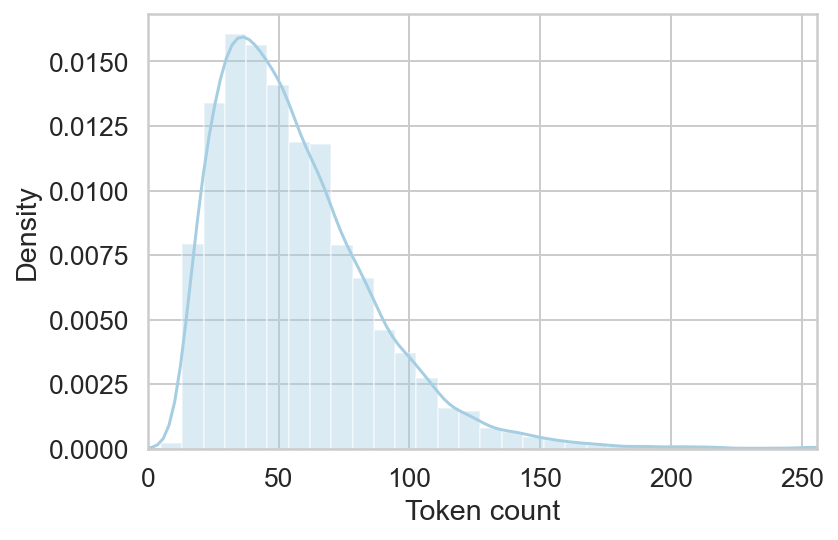

In [18]:
token_length_list = []

for txt in df.answer:
    if pd.isna(txt) or txt == "": 
         continue  # Skip to the next text
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_length_list.append(len(tokens))
    
sns.distplot(token_length_list)

plt.xlim([0,256])

plt.xlabel('Token count')

C:\Users\omkar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

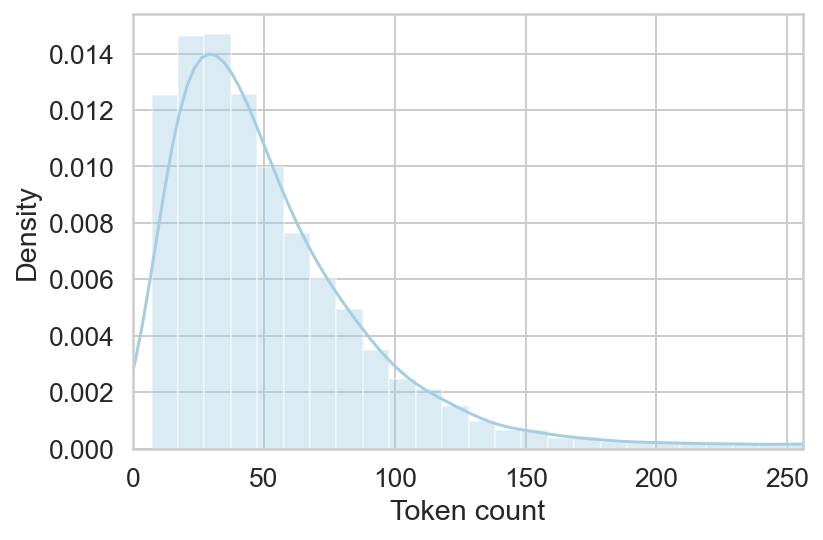

In [19]:
token_length_list2 = []

for i in df.random_answer_list:
    if pd.isna(i) or i == "":  # Use 'i' to check for emptiness
        continue  # Skip to the next text
    tokens = tokenizer.encode(i, truncation=True, max_length=512)
    token_length_list2.append(len(tokens))  # Append to the correct list
    
sns.distplot(token_length_list2)
plt.xlim([0,256])
plt.xlabel('Token count') 


In [20]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state= RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(8000, 8) (1000, 8) (1001, 8)


In [21]:
import tensorflow as tf

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
from transformers import DataCollatorWithPadding

MAX_LEN = 160
BATCH_SIZE = 32

class GradeDataset(Dataset):
    def __init__(self, modelanswers, studentanswers, targets, tokenizer, max_len, include_raw_modelanswer = False, include_raw_studentanswer = False):
        self.modelanswers = modelanswers
        self.studentanswers = studentanswers
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        # No longer needed:
        self.include_raw_modelanswer = include_raw_modelanswer 
        self.include_raw_studentanswer = include_raw_studentanswer 

    def __len__(self):
        return len(self.studentanswers)

    def __getitem__(self, item):
        modelanswer = str(self.modelanswers[item])
        studentanswer = str(self.studentanswers[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            modelanswer,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True,
            padding=True, 
            return_tensors='pt'
        )

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
        
        if self.include_raw_modelanswer:
            output['model_answer'] = modelanswer
        
        if self.include_raw_studentanswer:
            output['student_answer'] = studentanswer
        
            
        return output


pre_trained_model_ckpt = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

class CustomCollatorWithPadding(DataCollatorWithPadding):
    def __call__(self, batch):
        numerical_features = ['input_ids', 'attention_mask', 'targets']  
        text_features = ['model_answer', 'student_answer']

        batch_encodings = {feature: [item[feature] for item in batch] for feature in numerical_features}
        batch_text = {
           'model_answer_text':  [item['model_answer'] for item in batch],
           'student_answer_text': [item['student_answer'] for item in batch]
        }
        # Apply padding and numericalization via the base DataCollator
        padded_batch = super().__call__(batch_encodings)  

        # Add the text data to the padded batch
        padded_batch.update(batch_text)
        
        return padded_batch
    
collator = CustomCollatorWithPadding(tokenizer=tokenizer, padding = 'longest')
    
def create_data_loader(df, tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE, include_raw_modelanswer = False, include_raw_studentanswer = False):
    ds = GradeDataset(
        modelanswers = df['answer'].to_list(),
        studentanswers = df['random_answer_list'].to_list(),
        targets = df.Grades.to_list(),
        tokenizer = tokenizer,
        max_len = max_len,
        include_raw_modelanswer = include_raw_modelanswer,
        include_raw_studentanswer = include_raw_studentanswer
    )
    return DataLoader(ds, batch_size = batch_size, collate_fn = collator)
    
        

In [23]:
train_data_loader = create_data_loader(df_train, tokenizer, include_raw_modelanswer = True, include_raw_studentanswer = True)

val_data_loader = create_data_loader(df_val, tokenizer, include_raw_modelanswer = True, include_raw_studentanswer = True)

test_data_loader = create_data_loader(df_test, tokenizer, include_raw_modelanswer = True, include_raw_studentanswer = True)

In [24]:
for d in val_data_loader:
    print(d.keys())

dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
dict_keys(['input_id

In [25]:
data = next(iter(train_data_loader))

print(data.keys())

print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['targets'].shape)

dict_keys(['input_ids', 'attention_mask', 'targets', 'model_answer_text', 'student_answer_text'])
torch.Size([32, 135])
torch.Size([32, 135])
torch.Size([32])


In [26]:
pre_trained_model_ckpt = 'bert-base-uncased'

class GradeClassifier(nn.Module):
    def __init__(self, n_classes):
        super(GradeClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pre_trained_model_ckpt, return_dict = False)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [27]:
class_names = ['F-Grade', 'C-Grade', 'B-Grade', 'A-Grade', 'O-Grade']

model = GradeClassifier(len(class_names))

model = model.to(device)

input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

F.softmax(model(input_ids, attention_mask), dim = 1)

tensor([[0.1557, 0.2367, 0.3400, 0.1409, 0.1268],
        [0.0588, 0.0601, 0.3580, 0.2675, 0.2556],
        [0.1658, 0.2522, 0.2648, 0.1819, 0.1353],
        [0.1373, 0.1226, 0.3341, 0.1788, 0.2272],
        [0.1911, 0.1779, 0.3382, 0.1623, 0.1305],
        [0.1581, 0.1430, 0.2875, 0.2685, 0.1429],
        [0.1169, 0.0564, 0.5135, 0.1537, 0.1595],
        [0.1224, 0.1658, 0.3152, 0.2219, 0.1746],
        [0.1506, 0.1311, 0.3805, 0.2359, 0.1019],
        [0.1689, 0.1683, 0.3039, 0.1877, 0.1713],
        [0.1323, 0.2275, 0.2984, 0.0935, 0.2482],
        [0.1330, 0.1193, 0.3573, 0.2627, 0.1278],
        [0.1892, 0.1592, 0.3159, 0.1339, 0.2017],
        [0.1583, 0.1841, 0.3292, 0.1719, 0.1565],
        [0.1899, 0.1883, 0.3474, 0.1605, 0.1140],
        [0.1859, 0.1342, 0.3598, 0.1875, 0.1326],
        [0.1466, 0.1875, 0.3348, 0.1989, 0.1321],
        [0.2268, 0.1861, 0.2228, 0.1311, 0.2331],
        [0.1629, 0.1388, 0.4184, 0.1525, 0.1275],
        [0.0947, 0.1100, 0.4772, 0.1487, 0.1695],


In [28]:
EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr = 1e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [29]:
from tqdm.auto import tqdm

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets).cpu()
        
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        
        optimizer.step()
        scheduler.step()
        
    return correct_predictions/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets).cpu()
        
        losses.append(loss.item())
        
    return correct_predictions/n_examples, np.mean(losses)


def get_predictions(model, data_loader):
    model = model.eval()
    model_answer = []
    student_answer = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            model_ans = d['model_answers']
            student_ans = d['student_answers']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
                          
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim = 1)
                          
            probs = F.softmax(outputs, dim = 1)
                          
            model_answer.extend(model_ans)
            student_answer.extend(student_ans)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
                          
                          
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
                          
    return model_answer, student_answer, predictions, prediction_probs, real_values

In [ ]:
from tqdm.auto import tqdm

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1} / {EPOCHS}')
    
    train_loop = tqdm(train_data_loader, leave = True)
    model.train()
    
    running_loss = 0.0
    running_acc = 0.0
    
    train_acc, train_loss = train_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    
    train_acc = running_acc/ len(df_train)
    train_acc = running_loss/ len(df_train)
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    
    val_loop = tqdm(val_data_loader, leave = True)
    model.eval()
    
    running_loss1 = 0.0
    running_acc2 = 0.0
    
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
   
    val_acc = running_acc/ len(df_val)
    val_acc = running_loss/ len(df_val)
 
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model.bin')
        best_accuracy = val_acc
    

Epoch 1 / 10


  0%|          | 0/250 [00:01<?, ?it/s]